# Task:
## Semantically segment objects from image **AUTOMATICALLY** with the help of **META AI SAM**, without PROMPTS/TRAINING

---

### Segment all the pepperoni pieces from the pizza topping

![](https://i2.wp.com/lifemadesimplebakes.com/wp-content/uploads/2014/09/Classic-Pepperoni-Pizza-1.jpg)

---

## Approach:

![](https://raw.githubusercontent.com/yogendra-yatnalkar/SAM-Automatic-Semantic-Segmentation/main/support-assets/SAM-Automatic-Semantic-Segmentation.png)

**1. Automatic Mask Generation (AMG)**

Utilizing the Segment Anything Model (SAM) from the MetaAI SAM repository, perform instance segmentation on the entire image. This process will identify and isolate individual objects within the image.

**2. Patch-Embedding Extraction & Single Representation per Instance-Segment**

- For each generated instance-segment, extract the corresponding patch embedding. A patch embedding encapsulates a segment's visual features into a concise vector representation.

- To ensure effective association of each cluster with its corresponding segmentation mask, each instance segmentation mask should have a unique single embedding or single representation. **This mapping allows for the accurate assignment of semantic segmentation classes to individual objects.**

- To achieve this, we can extract all the patch embeddings from the encoder features of SAM and average them per segment.

**3. Clustering for Semantic Segmentation**

Treating each segment as a distinct data point, apply clustering algorithms to group similar segments together. Each resulting cluster represents a semantic segmentation class, encompassing objects with shared visual characteristics.

---
---

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Sep 10 07:10:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Detailed Explanation

#### Patch Embedding and SAM Encoder

- Extract all patch embeddings from the SAM Encoder.

- The SAM model takes an input of **1024x1024** pixels.

- The default patch size is **16x16** pixels.

- Therefore, the input structure is **64x64x16x16**, where there are 64x64 patches, each with a size of 16x16 pixels.

- The SAM Encoder output is **256x64x64**.

- After shuffling the channels, the output becomes **64x64x256**.

- Observe the input-output transformation:
  
  ```
  64x64x16x16 --> 64x64x256
  ```

- This means that each 16x16 patch is represented by a 256-dimensional embedding vector.

#### Segment Embedding

- For each segment, find the corresponding patches and average their embedding vectors.
- For example, if there are 30 segments identified using Meta SAM Automatic Mask Generator (AMG), iterate through each segment and:
  1. Identify the corresponding patches and obtain their embeddings. For instance, if segment1 corresponds to **3 patches**, its patch embedding will be **3x256**. Similarly, if segment2 corresponds to **10 patches**, its patch embedding will be **10x256**.
  2. Average all the patch embeddings corresponding to that segment to obtain a single embedding vector. As a result, segment1's embedding vector will be **1x256**, segment2's embedding vector will be **1x256**, and so on.
- This process results in a **1x256 embedding vector** for each segment. For 30 segments, the representation will be **30x256**.

#### Semantic Class Clustering

- Cluster the segment embedding vectors using a clustering algorithm, such as **DBScan**. This algorithm is suitable since the number of segments is unknown.
- Each cluster formed represents a distinct semantic class.**


 ## Setting up of SAM model for Automatic Mask Generation

In [4]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://i2.wp.com/lifemadesimplebakes.com/wp-content/uploads/2014/09/Classic-Pepperoni-Pizza-1.jpg

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8_cvjb6c
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8_cvjb6c
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=6ebc2932700f10f7aafc1323a4fe2b8154c8155508f32d0baf846fd8d408b064
  Stored in directory: /tmp/pip-ephem-wheel-cache-pbxxa963/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
--2025-09-10 07:11:37--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.33, 3.171.22.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|

In [5]:
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
from sklearn.cluster import DBSCAN
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA is available: True


In [6]:
# SAM initial model loading
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.9]])
        img[m] = color_mask
    ax.imshow(img)

### Sample image

IMG shape:  (1024, 1024, 3)


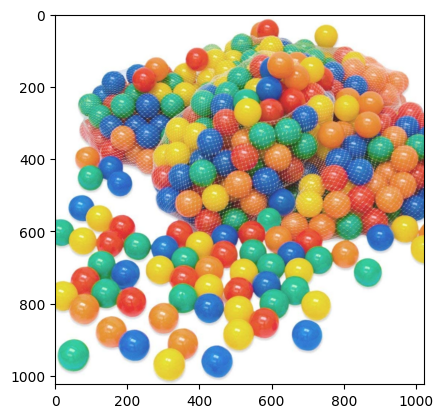

In [104]:
#img_path = "/content/Classic-Pepperoni-Pizza-1.jpg"
# img_path = "/content/us.jpeg"
# img_path = "/content/img2.jpeg"
img_path = "/content/poolbals.jpg"
# img_path = "/content/forest.jpg"

#img_path = "/home/beloslava/Downloads/img2.jpeg"

img = cv2.imread(img_path)

# resizing the image to 1024x1024
img = cv2.resize(img, (1024, 1024))
print("IMG shape: ", img.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Sample image instance segmentation with Automatic-Mask-Generation

In [105]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=51,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

### Get the encoder embeddings

In [106]:
mask_generator.predictor.set_image(img_rgb)
enc_emb = mask_generator.predictor.features
enc_emb = enc_emb.to("cpu").numpy()
enc_emb = enc_emb[0].transpose((1,2,0))

print(enc_emb.shape)

(64, 64, 256)


### Generate mask using automatic-mask-generator

In [107]:
masks2 = mask_generator.generate(img_rgb)
masks2 = sorted(masks2, key=(lambda x: x['area']), reverse=True)
print("Number of masks: ", len(masks2))
print("Shape of individual mask: ",masks2[0]['segmentation'].shape)

Number of masks:  346
Shape of individual mask:  (1024, 1024)


In [ ]:
!nvidia-smi

Tue Sep  9 17:27:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             52W /  400W |    6799MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

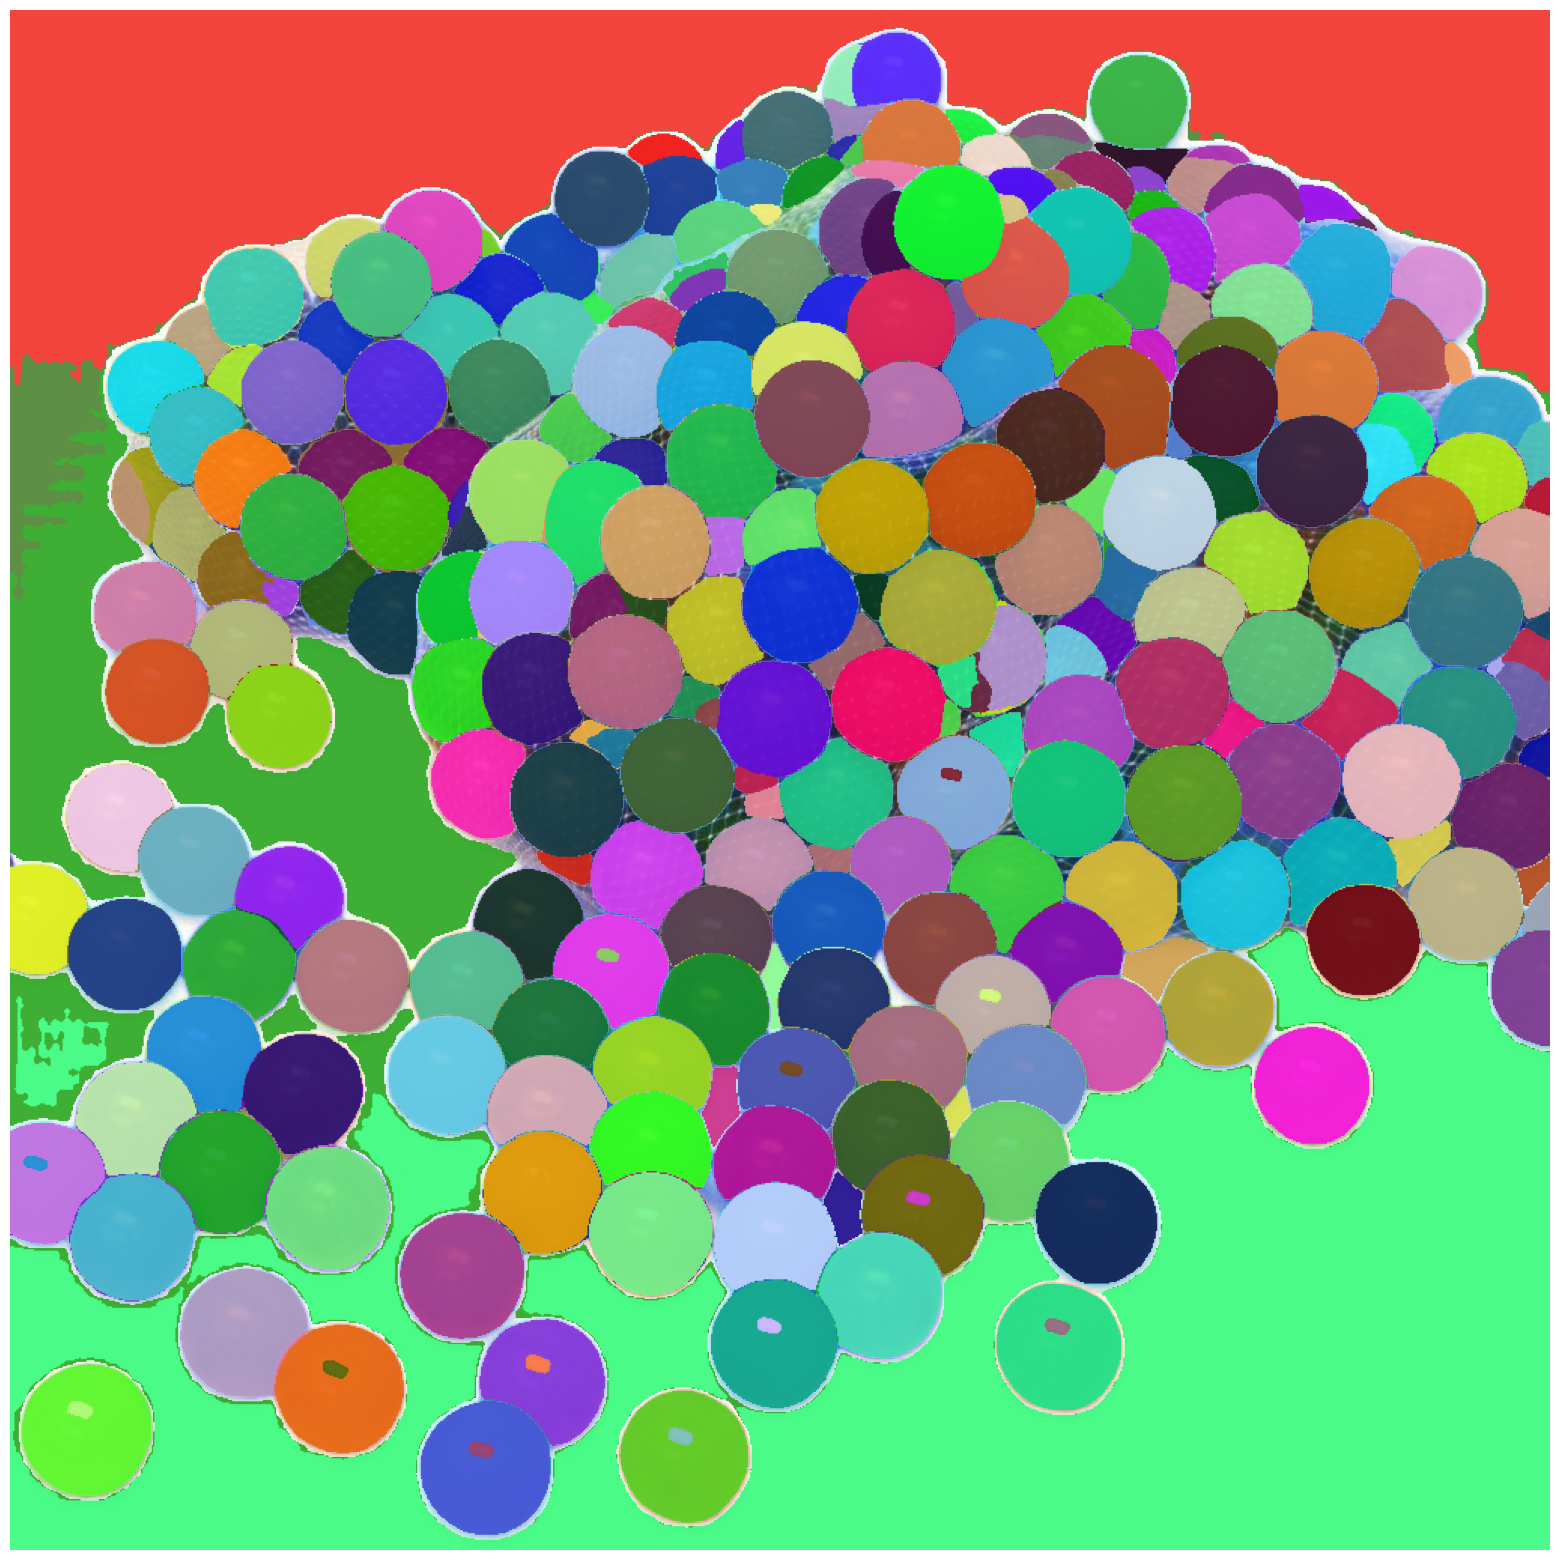

In [108]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(masks2)
plt.axis('off')
plt.show()

## Get Mask Embedding for each segment:

#### Mask Embedding = Average of patch embeddings corresponding to individual segment

---

### Notes:

- As we can see, there are 264 masks created using Automatic-Mask-Generator
- The output-shape of encoder is: 256x64x64 --> which means its a 64x64 image with 256 channels
- **For each mask, get all the corresponding patch-embedding**
- **The average of all patch-embeddings for a given mask will be termed as "Mask Embedding"**

In [109]:
def get_mask_embedding_using_patch_embeddings(mask, enc_emb, return_all = False):
    # Converting mask of shape 1024x1024 to shape: 64x64x16x16
    # This assumes that patch size is 16x16 becuase what we mainly need is: 64x64 at the start
    # We are free to change the patch-size accordingly
    split_mask = np.array(np.split(mask, 64, axis = -1))
    split_mask = np.array(np.split(split_mask, 64, axis = -2))
    split_mask = split_mask*1 # split_mask is a mask of shape: 64x64x16x16
    # split_mask is binary (have value of 0 or 1 not between)

    # Converting split_mask of shape: 64x64x16x16 to 64x64
    # by adding all numbers in every 16x16 grid
    split_mask = np.sum(split_mask, axis = -1)
    split_mask = np.sum(split_mask, axis = -1)

    # Get all patch embeddings from this split_mask of 64x64
    # In this split_mask, at all locations where the cell-value is greater than 1,
    # It means that we need to pick the patch-embeddding at this given index (X,Y) value
    patch_locations = np.where(split_mask > 1)
    n_patch_embeddings = enc_emb[patch_locations]
    mask_embedding = n_patch_embeddings.mean(axis = 0, keepdims = False)

    if return_all:
        return mask_embedding, patch_locations, n_patch_embeddings
    return mask_embedding

#### NOTE:

- As you can see, post averaging out patch embedding for each segment, we get a mask-embedding of shape: 1x256.
- Since,we had 264 segments identified, our final vector for 264 segments will be of shape: **264x256**. (we will call it **Mask Embeddings**)
- These Mask-Embeddings will be passed on to **DBScan for clustering, where each individual cluster formed will be considered as a Semantic Class**.

In [110]:
masks2_embeddings_li = []
for i in range(len(masks2)):
    nth_mask = masks2[i]['segmentation']
    nth_mask_emb = get_mask_embedding_using_patch_embeddings(nth_mask, enc_emb)
    masks2_embeddings_li.append(nth_mask_emb)

masks2_embeddings_arr = np.array(masks2_embeddings_li)
print("Mask Embedding shape: ", masks2_embeddings_arr.shape)

Mask Embedding shape:  (346, 256)


## Clustering using DBScan

In [111]:
# Clustering using DB Scan
clustering = DBSCAN(
    eps=0.06,
    min_samples=8,
    metric="cosine"
).fit(masks2_embeddings_arr)

print("Clustering Labels: ", np.unique(clustering.labels_))

Clustering Labels:  [-1  0]


### Label 0 Semantic Mask

Number of items in cluster 0:  (193,)


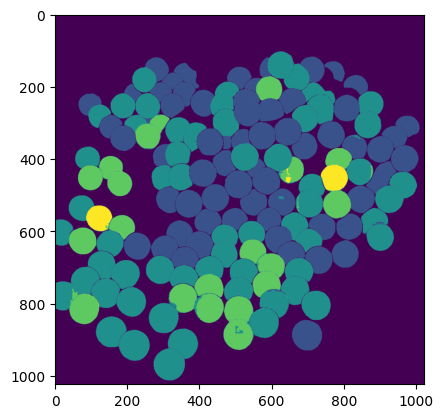

In [112]:
label_0 = np.where(clustering.labels_ == 0)
print("Number of items in cluster 0: ", label_0[0].shape)

lbl0_semantic_seg_mask = masks2[-1]['segmentation']*1
for seg_no in label_0[0]:
    lbl0_semantic_seg_mask += masks2[seg_no]['segmentation']*1

# Plottign the label 0 semantic mask
plt.imshow(lbl0_semantic_seg_mask)

## Final Output

In [113]:
binary_ind = np.where(lbl0_semantic_seg_mask > 0)
mask = lbl0_semantic_seg_mask.copy()
mask[binary_ind] = 1

img_mask = img_rgb.copy()
img_mask[:,:,0] = img_mask[:,:,0]*mask
img_mask[:,:,1] = img_mask[:,:,1]*mask
img_mask[:,:,2] = img_mask[:,:,2]*mask

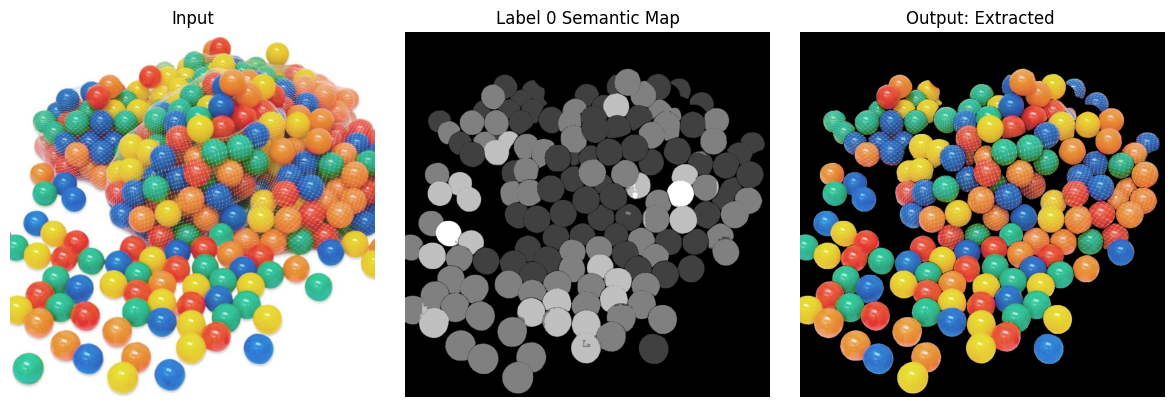

In [114]:
# Create a figure and three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the first image on the first subplot
axes[0].imshow(img_rgb, cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')  # Hide axes

# Plot the second image on the second subplot
axes[1].imshow(lbl0_semantic_seg_mask, cmap='gray')
axes[1].set_title('Label 0 Semantic Map')
axes[1].axis('off')  # Hide axes

# Plot the third image on the third subplot
axes[2].imshow(img_mask, cmap='gray')
axes[2].set_title('Output: Extracted ')
axes[2].axis('off')  # Hide axes

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [115]:
import numpy as np

def sam_masks_to_dict(masks):
    """
    Convert SAM masks list into a dict keyed by mask_id strings.

    Args:
      masks: list of dicts from mask_generator.generate(img)
    Returns:
      dict: keys = "mask_000", values = metadata dict (area, bbox, etc.)
    """
    mask_dict = {}
    for i, ann in enumerate(masks):
        key = f"mask_{i:03d}"
        # core metadata
        rec = {
            "mask_id": i,
            "area": int(ann.get("area", 0)),
            "bbox": [int(x) for x in ann.get("bbox", [0,0,0,0])],
            "predicted_iou": float(ann.get("predicted_iou", -1)),
            "stability_score": float(ann.get("stability_score", -1)),
            # keep the segmentation as a numpy array in-memory
            "segmentation": ann["segmentation"].astype(np.uint8),
        }
        # optional provenance if present
        if "crop_box" in ann:
            rec["crop_box"] = [int(x) for x in ann["crop_box"]]
        if "point_coords" in ann:
            rec["point_coords"] = ann["point_coords"]
        if "point_labels" in ann:
            rec["point_labels"] = ann["point_labels"]

        mask_dict[key] = rec

    return mask_dict


In [116]:
masks = mask_generator.generate(img_rgb)
mask_data = sam_masks_to_dict(masks)

# Inspect keys
print(mask_data.keys())   # e.g., dict_keys(['mask_000','mask_001',...])

# Access one mask's info
m0 = mask_data["mask_000"]
print("Area:", m0["area"], "BBox:", m0["bbox"], "IoU:", m0["predicted_iou"])

# Get the segmentation mask (numpy array, shape HxW)
mask_img = m0["segmentation"]
print(mask_img.shape, mask_img.dtype)


dict_keys(['mask_000', 'mask_001', 'mask_002', 'mask_003', 'mask_004', 'mask_005', 'mask_006', 'mask_007', 'mask_008', 'mask_009', 'mask_010', 'mask_011', 'mask_012', 'mask_013', 'mask_014', 'mask_015', 'mask_016', 'mask_017', 'mask_018', 'mask_019', 'mask_020', 'mask_021', 'mask_022', 'mask_023', 'mask_024', 'mask_025', 'mask_026', 'mask_027', 'mask_028', 'mask_029', 'mask_030', 'mask_031', 'mask_032', 'mask_033', 'mask_034', 'mask_035', 'mask_036', 'mask_037', 'mask_038', 'mask_039', 'mask_040', 'mask_041', 'mask_042', 'mask_043', 'mask_044', 'mask_045', 'mask_046', 'mask_047', 'mask_048', 'mask_049', 'mask_050', 'mask_051', 'mask_052', 'mask_053', 'mask_054', 'mask_055', 'mask_056', 'mask_057', 'mask_058', 'mask_059', 'mask_060', 'mask_061', 'mask_062', 'mask_063', 'mask_064', 'mask_065', 'mask_066', 'mask_067', 'mask_068', 'mask_069', 'mask_070', 'mask_071', 'mask_072', 'mask_073', 'mask_074', 'mask_075', 'mask_076', 'mask_077', 'mask_078', 'mask_079', 'mask_080', 'mask_081', 'mask

In [117]:
print(mask_data)

{'mask_000': {'mask_id': 0, 'area': 4587, 'bbox': [666, 486, 75, 76], 'predicted_iou': 1.0188850164413452, 'stability_score': 0.9846253991127014, 'segmentation': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'crop_box': [338, 338, 686, 686], 'point_coords': [[708.44, 488.91999999999996]]}, 'mask_001': {'mask_id': 1, 'area': 3417, 'bbox': [511, 624, 73, 66], 'predicted_iou': 1.0168756246566772, 'stability_score': 0.9860748648643494, 'segmentation': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'crop_box': [338, 338, 686, 686], 'point_coords': [[543.8000000000001, 653.56]]}, 'mask_002': {'mask_id': 2, 'area': 3192, 'bbox': [618, 392, 70, 76], 'pred

Saving Basketball.png to Basketball (20).png


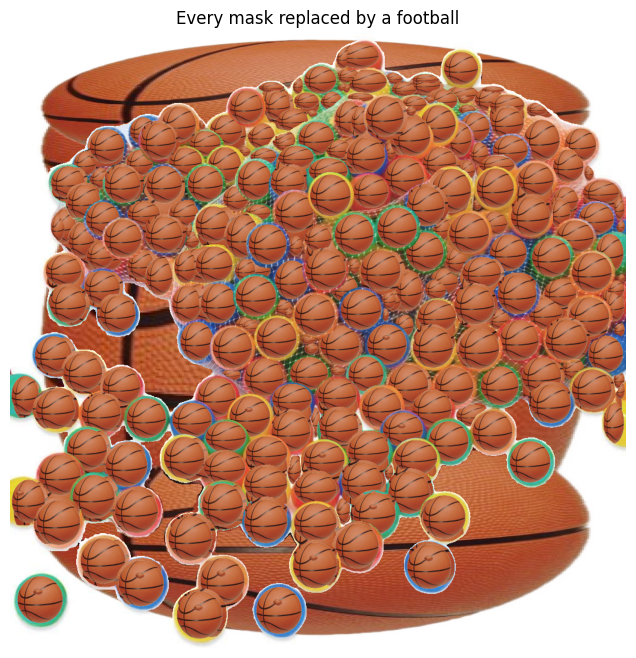

In [118]:
# --- Upload or pick a football image ---
# Option A: upload from your computer
try:
    from google.colab import files
    up = files.upload()  # pick a football image (PNG/JPG)
    football_path = list(up.keys())[0]
except Exception:
    football_path = None

# Option B: fallback from URL if nothing uploaded
if not football_path:
    import urllib.request, os
    football_url = "https://upload.wikimedia.org/wikipedia/commons/6/6e/Football_%28soccer_ball%29.svg"  # replace if you prefer a raster image
    football_path = "football.png"
    try:
        urllib.request.urlretrieve(football_url, football_path)
    except Exception:
        pass  # if this fails, upload via Option A

import cv2
import numpy as np
from math import floor, ceil
import matplotlib.pyplot as plt

def imread_rgba(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read football image at: {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        # add opaque alpha
        h, w = img.shape[:2]
        a = np.full((h, w, 1), 255, np.uint8)
        img = np.concatenate([img, a], axis=2)
    # BGRA -> RGBA
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img

def to_rgba(img_rgb):
    """RGB -> RGBA (opaque)"""
    if img_rgb.shape[2] == 3:
        a = np.full(img_rgb.shape[:2] + (1,), 255, np.uint8)
        return np.concatenate([img_rgb, a], axis=2)
    return img_rgb

def alpha_composite(dst_rgba, src_rgba, x, y):
    """Paste src_rgba onto dst_rgba at (x,y) using src alpha. All RGBA uint8."""
    H, W = dst_rgba.shape[:2]
    h, w = src_rgba.shape[:2]
    if w <= 0 or h <= 0:
        return
    x0, y0 = max(0, int(x)), max(0, int(y))
    x1, y1 = min(W, x0 + int(w)), min(H, y0 + int(h))
    if x1 <= x0 or y1 <= y0:
        return
    sx0, sy0 = x0 - int(x), y0 - int(y)
    sx1, sy1 = sx0 + (x1 - x0), sy0 + (y1 - y0)

    dst = dst_rgba[y0:y1, x0:x1].astype(np.float32)
    src = src_rgba[sy0:sy1, sx0:sx1].astype(np.float32)

    a = src[:, :, 3:4] / 255.0
    out_rgb = a * src[:, :, :3] + (1.0 - a) * dst[:, :, :3]
    out_a   = np.clip(np.maximum(dst[:, :, 3:4], src[:, :, 3:4]), 0, 255)

    dst_rgba[y0:y1, x0:x1, :3] = out_rgb.clip(0, 255).astype(np.uint8)
    dst_rgba[y0:y1, x0:x1, 3:4] = out_a.astype(np.uint8)

def replace_every_mask_with_football(img_rgb, mask_data, football_rgba, keep_aspect=False):
    """
    For each mask: resize football to bbox and paste inside mask region (mask acts as matte).
    img_rgb: original image (H,W,3 RGB)
    mask_data: dict like {"mask_000": {..., 'bbox':[x,y,w,h], 'segmentation': HxW uint8}}
    football_rgba: RGBA uint8 football image
    keep_aspect: if True, letterbox inside bbox while preserving football aspect
    """
    H, W = img_rgb.shape[:2]
    canvas = to_rgba(img_rgb.copy())  # RGBA

    # Paste larger regions first (helps with overlaps)
    entries = list(mask_data.items())
    entries.sort(key=lambda kv: kv[1].get("area", 0), reverse=True)

    for key, info in entries:
        x, y, w, h = info["bbox"]
        # clip bbox to image bounds
        x = max(0, int(x)); y = max(0, int(y))
        w = max(1, min(int(w), W - x)); h = max(1, min(int(h), H - y))
        if w <= 0 or h <= 0:
            continue

        # Prepare a football tile to fit the bbox
        if keep_aspect:
            # scale to fit within bbox, preserving aspect
            fh, fw = football_rgba.shape[:2]
            scale = min(w / fw, h / fh)
            tw, th = max(1, int(round(fw * scale))), max(1, int(round(fh * scale)))
            resized = cv2.resize(football_rgba, (tw, th), interpolation=cv2.INTER_AREA)
            # letterbox into bbox (centered)
            tile = np.zeros((h, w, 4), np.uint8)
            ox = (w - tw) // 2
            oy = (h - th) // 2
            tile[oy:oy+th, ox:ox+tw] = resized
        else:
            # stretch to bbox
            tile = cv2.resize(football_rgba, (w, h), interpolation=cv2.INTER_AREA)

        # Build a matte from the mask crop (so we only reveal within the mask)
        seg = info["segmentation"]  # HxW uint8 (0/1 or 0/255)
        if seg.dtype != np.uint8:
            seg = seg.astype(np.uint8)
        if seg.max() == 1:
            seg = seg * 255
        matte = seg[y:y+h, x:x+w]
        if matte.size == 0:
            continue
        # combine football's own alpha (if any) with mask matte
        a_tile = tile[:, :, 3]
        combined_alpha = (a_tile.astype(np.float32) / 255.0) * (matte.astype(np.float32) / 255.0)
        tile_rgba = tile.copy()
        tile_rgba[:, :, 3] = np.clip(combined_alpha * 255.0, 0, 255).astype(np.uint8)

        # Composite onto canvas
        alpha_composite(canvas, tile_rgba, x, y)

    # Back to RGB for display/saving if you want
    out_rgb = canvas[:, :, :3]
    return out_rgb

# --- Load football and run ---
football_rgba = imread_rgba(football_path)
out_rgb = replace_every_mask_with_football(img_rgb, mask_data, football_rgba, keep_aspect=False)

plt.figure(figsize=(8,8))
plt.imshow(out_rgb)
plt.axis("off")
plt.title("Every mask replaced by a football")
plt.show()


Saving Basketball.png to Basketball (21).png


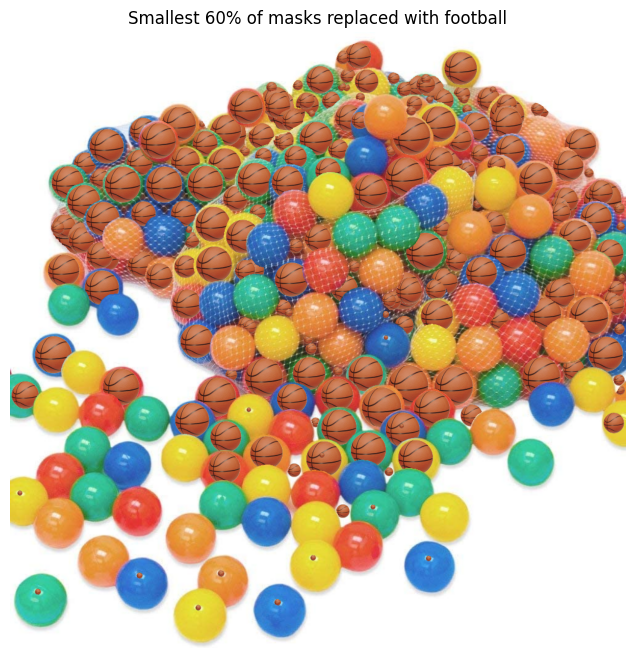

In [119]:
# --- Replace only the smallest 60% of masks with a football image ---

import cv2, numpy as np, matplotlib.pyplot as plt, urllib.request, os, math
from google.colab import files

# ---------- helpers ----------
def imread_rgba(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        h, w = img.shape[:2]
        a = np.full((h, w, 1), 255, np.uint8)
        img = np.concatenate([img, a], axis=2)
    # BGRA -> RGBA
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img

def to_rgba(img_rgb):
    if img_rgb.shape[2] == 3:
        a = np.full(img_rgb.shape[:2] + (1,), 255, np.uint8)
        return np.concatenate([img_rgb, a], axis=2)
    return img_rgb

def alpha_composite(dst_rgba, src_rgba, x, y):
    """Paste src_rgba onto dst_rgba at (x,y) using src alpha. All RGBA uint8."""
    H, W = dst_rgba.shape[:2]
    h, w = src_rgba.shape[:2]
    if w <= 0 or h <= 0:
        return
    x0, y0 = max(0, int(x)), max(0, int(y))
    x1, y1 = min(W, x0 + int(w)), min(H, y0 + int(h))
    if x1 <= x0 or y1 <= y0:
        return
    sx0, sy0 = x0 - int(x), y0 - int(y)
    sx1, sy1 = sx0 + (x1 - x0), sy0 + (y1 - y0)

    dst = dst_rgba[y0:y1, x0:x1].astype(np.float32)
    src = src_rgba[sy0:sy1, sx0:sx1].astype(np.float32)

    a = src[:, :, 3:4] / 255.0
    out_rgb = a * src[:, :, :3] + (1.0 - a) * dst[:, :, :3]
    out_a   = np.clip(np.maximum(dst[:, :, 3:4], src[:, :, 3:4]), 0, 255)

    dst_rgba[y0:y1, x0:x1, :3] = out_rgb.clip(0, 255).astype(np.uint8)
    dst_rgba[y0:y1, x0:x1, 3:4] = out_a.astype(np.uint8)

def replace_subset_with_football(img_rgb, mask_data, football_rgba, keep_aspect=False, fraction=0.60):
    """
    Replace the smallest `fraction` of masks (by area) with the football image.
    - img_rgb: RGB uint8 image (H,W,3)
    - mask_data: dict { "mask_000": {"area":..., "bbox":[x,y,w,h], "segmentation": HxW uint8}, ... }
    - football_rgba: RGBA uint8
    - keep_aspect: if True, letterbox football inside bbox; else stretch to bbox
    - fraction: portion of smallest masks to replace (0.60 = 60%)
    Returns: RGB uint8 image with replacements composited.
    """
    H, W = img_rgb.shape[:2]
    canvas = to_rgba(img_rgb.copy())  # start from original

    # Build a list with valid masks
    items = []
    for k, info in mask_data.items():
        area = int(info.get("area", 0))
        bbox = info.get("bbox", [0,0,0,0])
        if not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
            continue
        x, y, w, h = bbox
        if area <= 0 or w <= 0 or h <= 0:
            continue
        items.append((k, info))

    if not items:
        return canvas[:, :, :3]

    # Sort by area ascending (smallest first), pick the bottom fraction
    items.sort(key=lambda kv: int(kv[1].get("area", 0)))
    k = max(1, int(math.ceil(fraction * len(items))))
    to_replace = items[:k]

    # Paste selection; for stability, paste larger among the selected first
    to_replace.sort(key=lambda kv: int(kv[1].get("area", 0)), reverse=True)

    for key, info in to_replace:
        x, y, w, h = [int(v) for v in info["bbox"]]
        # clip bbox
        x = max(0, x); y = max(0, y)
        w = max(1, min(w, W - x)); h = max(1, min(h, H - y))
        if w <= 0 or h <= 0:
            continue

        # Prepare football to fit bbox
        if keep_aspect:
            fh, fw = football_rgba.shape[:2]
            scale = min(w / fw, h / fh)
            tw, th = max(1, int(round(fw * scale))), max(1, int(round(fh * scale)))
            resized = cv2.resize(football_rgba, (tw, th), interpolation=cv2.INTER_AREA)
            # letterbox center
            tile = np.zeros((h, w, 4), np.uint8)
            ox = (w - tw) // 2
            oy = (h - th) // 2
            tile[oy:oy+th, ox:ox+tw] = resized
        else:
            tile = cv2.resize(football_rgba, (w, h), interpolation=cv2.INTER_AREA)

        # Build matte from mask crop AND football alpha
        seg = info["segmentation"]
        if seg.dtype != np.uint8:
            seg = seg.astype(np.uint8)
        if seg.max() == 1:
            seg = seg * 255
        matte = seg[y:y+h, x:x+w]
        if matte.size == 0:
            continue
        a_tile = tile[:, :, 3]
        combined_alpha = (a_tile.astype(np.float32) / 255.0) * (matte.astype(np.float32) / 255.0)
        tile_rgba = tile.copy()
        tile_rgba[:, :, 3] = np.clip(combined_alpha * 255.0, 0, 255).astype(np.uint8)

        # Composite onto canvas
        alpha_composite(canvas, tile_rgba, x, y)

    return canvas[:, :, :3]

# ---------- pick / fetch football image ----------
football_path = None
try:
    uploaded = files.upload()  # choose a football PNG/JPG if you want
    if uploaded:
        football_path = list(uploaded.keys())[0]
except Exception:
    pass

if not football_path:
    # fallback to a sample football (raster) if nothing uploaded
    football_path = "football_sample.png"
    if not os.path.exists(football_path):
        url = "https://upload.wikimedia.org/wikipedia/commons/0/09/Soccer_ball.svg.png"
        urllib.request.urlretrieve(url, football_path)

football_rgba = imread_rgba(football_path)

# ---------- run replacement on smallest 60% ----------
out_rgb = replace_subset_with_football(
    img_rgb=img_rgb,
    mask_data=mask_data,
    football_rgba=football_rgba,
    keep_aspect=True,      # set False to stretch to bbox
    fraction=0.60          # replace the smallest 60% masks
)

plt.figure(figsize=(8,8))
plt.imshow(out_rgb)
plt.axis("off")
plt.title("Smallest 60% of masks replaced with football")
plt.show()


Saving Basketball.png to Basketball (22).png


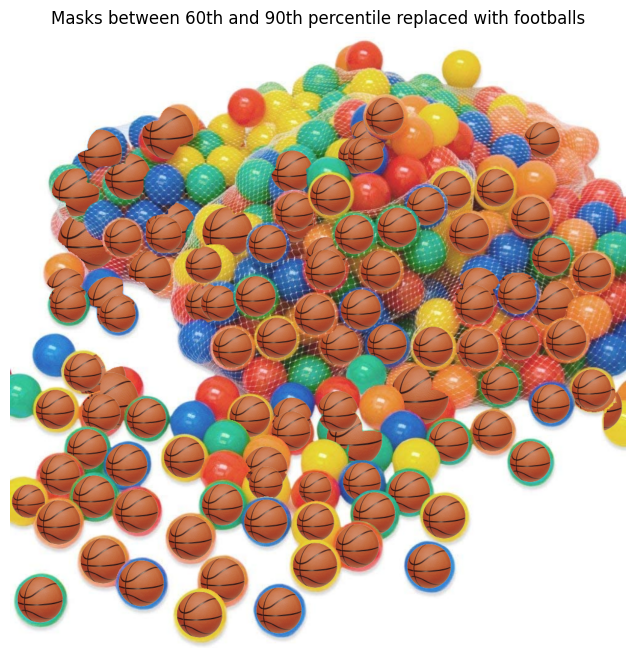

In [120]:
# --- Replace only masks between the 60th and 90th percentile in area ---

import cv2, numpy as np, matplotlib.pyplot as plt, urllib.request, os
from google.colab import files

# ---------- helpers ----------
def imread_rgba(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        h, w = img.shape[:2]
        a = np.full((h, w, 1), 255, np.uint8)
        img = np.concatenate([img, a], axis=2)
    # BGRA -> RGBA
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img

def to_rgba(img_rgb):
    if img_rgb.shape[2] == 3:
        a = np.full(img_rgb.shape[:2] + (1,), 255, np.uint8)
        return np.concatenate([img_rgb, a], axis=2)
    return img_rgb

def alpha_composite(dst_rgba, src_rgba, x, y):
    H, W = dst_rgba.shape[:2]
    h, w = src_rgba.shape[:2]
    if w <= 0 or h <= 0:
        return
    x0, y0 = max(0, int(x)), max(0, int(y))
    x1, y1 = min(W, x0 + int(w)), min(H, y0 + int(h))
    if x1 <= x0 or y1 <= y0:
        return
    sx0, sy0 = x0 - int(x), y0 - int(y)
    sx1, sy1 = sx0 + (x1 - x0), sy0 + (y1 - y0)

    dst = dst_rgba[y0:y1, x0:x1].astype(np.float32)
    src = src_rgba[sy0:sy1, sx0:sx1].astype(np.float32)

    a = src[:, :, 3:4] / 255.0
    out_rgb = a * src[:, :, :3] + (1.0 - a) * dst[:, :, :3]
    out_a   = np.clip(np.maximum(dst[:, :, 3:4], src[:, :, 3:4]), 0, 255)

    dst_rgba[y0:y1, x0:x1, :3] = out_rgb.clip(0, 255).astype(np.uint8)
    dst_rgba[y0:y1, x0:x1, 3:4] = out_a.astype(np.uint8)

def replace_percentile_range_with_football(img_rgb, mask_data, football_rgba,
                                           keep_aspect=True, lower=0.75, upper=0.99):
    """
    Replace only masks with area between [lower, upper] percentiles.
    - lower, upper: values in [0,1], e.g. 0.60=60th percentile, 0.90=90th percentile
    """
    H, W = img_rgb.shape[:2]
    canvas = to_rgba(img_rgb.copy())

    # collect valid masks
    items = []
    for k, info in mask_data.items():
        area = int(info.get("area", 0))
        bbox = info.get("bbox", [0,0,0,0])
        if not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
            continue
        x, y, w, h = bbox
        if area <= 0 or w <= 0 or h <= 0:
            continue
        items.append((k, info, area))

    if not items:
        return canvas[:, :, :3]

    # sort by area ascending
    items.sort(key=lambda t: t[2])
    n = len(items)
    lo_idx = int(round(lower * n))
    hi_idx = int(round(upper * n))
    to_replace = items[lo_idx:hi_idx]

    # paste larger ones first among selection
    to_replace.sort(key=lambda t: t[2], reverse=True)

    for key, info, area in to_replace:
        x, y, w, h = [int(v) for v in info["bbox"]]
        x = max(0, x); y = max(0, y)
        w = max(1, min(w, W - x)); h = max(1, min(h, H - y))
        if w <= 0 or h <= 0:
            continue

        if keep_aspect:
            fh, fw = football_rgba.shape[:2]
            scale = min(w / fw, h / fh)
            tw, th = max(1, int(round(fw * scale))), max(1, int(round(fh * scale)))
            resized = cv2.resize(football_rgba, (tw, th), interpolation=cv2.INTER_AREA)
            tile = np.zeros((h, w, 4), np.uint8)
            ox, oy = (w - tw) // 2, (h - th) // 2
            tile[oy:oy+th, ox:ox+tw] = resized
        else:
            tile = cv2.resize(football_rgba, (w, h), interpolation=cv2.INTER_AREA)

        seg = info["segmentation"]
        if seg.dtype != np.uint8:
            seg = seg.astype(np.uint8)
        if seg.max() == 1:
            seg = seg * 255
        matte = seg[y:y+h, x:x+w]
        if matte.size == 0:
            continue
        a_tile = tile[:, :, 3]
        combined_alpha = (a_tile.astype(np.float32)/255.0) * (matte.astype(np.float32)/255.0)
        tile_rgba = tile.copy()
        tile_rgba[:, :, 3] = np.clip(combined_alpha * 255.0, 0, 255).astype(np.uint8)

        alpha_composite(canvas, tile_rgba, x, y)

    return canvas[:, :, :3]

# ---------- pick / fetch football image ----------
football_path = None
try:
    uploaded = files.upload()  # optional: upload your football PNG/JPG
    if uploaded:
        football_path = list(uploaded.keys())[0]
except Exception:
    pass

if not football_path:
    football_path = "football_sample.png"
    if not os.path.exists(football_path):
        url = "https://upload.wikimedia.org/wikipedia/commons/0/09/Soccer_ball.svg.png"
        urllib.request.urlretrieve(url, football_path)

football_rgba = imread_rgba(football_path)

# ---------- run replacement on 60–90th percentile ----------
out_rgb = replace_percentile_range_with_football(
    img_rgb=img_rgb,
    mask_data=mask_data,
    football_rgba=football_rgba,
    keep_aspect=True,
    lower=0.60,
    upper=0.90
)

plt.figure(figsize=(8,8))
plt.imshow(out_rgb)
plt.axis("off")
plt.title("Masks between 60th and 90th percentile replaced with footballs")
plt.show()


How many images do you want to upload? 4

Upload image 1 of 4 …


Saving Basketball.png to Basketball (23).png

Upload image 2 of 4 …


Saving baseball-ball-rawlings-tvb850-85.jpg to baseball-ball-rawlings-tvb850-85 (7).jpg

Upload image 3 of 4 …


Saving images.jpeg to images (8).jpeg

Upload image 4 of 4 …


Saving kensis-rugby-ball-blue_1.jpg to kensis-rugby-ball-blue_1 (9).jpg

Collected 4 images: ['Basketball (23).png', 'baseball-ball-rawlings-tvb850-85 (7).jpg', 'images (8).jpeg', 'kensis-rugby-ball-blue_1 (9).jpg']


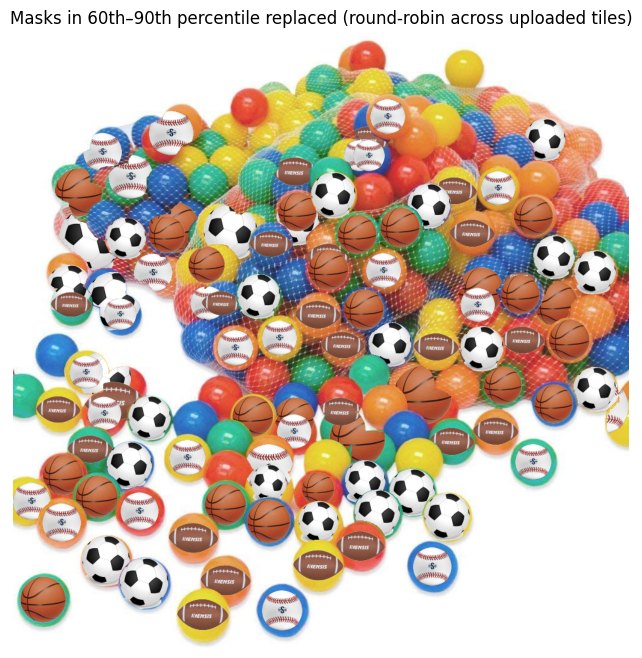

In [121]:
# --- Upload N images (prompted), make backgrounds transparent, and replace mid-percentile masks ---

import cv2, numpy as np, matplotlib.pyplot as plt, urllib.request, os, math
from google.colab import files

# ============ Helpers ============

def imread_rgba(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read: {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        h, w = img.shape[:2]
        a = np.full((h, w, 1), 255, np.uint8)
        img = np.concatenate([img, a], axis=2)
    # BGRA -> RGBA
    return cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)

def to_rgba(img_rgb):
    if img_rgb.shape[2] == 3:
        a = np.full(img_rgb.shape[:2] + (1,), 255, np.uint8)
        return np.concatenate([img_rgb, a], axis=2)
    return img_rgb

def alpha_composite(dst_rgba, src_rgba, x, y):
    H, W = dst_rgba.shape[:2]
    h, w = src_rgba.shape[:2]
    if w <= 0 or h <= 0: return
    x0, y0 = max(0, int(x)), max(0, int(y))
    x1, y1 = min(W, x0 + int(w)), min(H, y0 + int(h))
    if x1 <= x0 or y1 <= y0: return
    sx0, sy0 = x0 - int(x), y0 - int(y)
    sx1, sy1 = sx0 + (x1 - x0), sy0 + (y1 - y0)

    dst = dst_rgba[y0:y1, x0:x1].astype(np.float32)
    src = src_rgba[sy0:sy1, sx0:sx1].astype(np.float32)

    a = src[:, :, 3:4] / 255.0
    out_rgb = a * src[:, :, :3] + (1.0 - a) * dst[:, :, :3]
    out_a   = np.maximum(dst[:, :, 3:4], src[:, :, 3:4])
    dst_rgba[y0:y1, x0:x1, :3] = out_rgb.clip(0, 255).astype(np.uint8)
    dst_rgba[y0:y1, x0:x1, 3:4] = out_a.clip(0, 255).astype(np.uint8)

def auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.20):
    """
    Remove background by keying border color in LAB space + cleanup.
    Works well for product-style images with uniform-ish borders.
    """
    rgb = rgba[:, :, :3]
    H, W = rgb.shape[:2]
    # sample border pixels
    border = np.concatenate([rgb[0], rgb[-1], rgb[:,0], rgb[:,-1]], axis=0).astype(np.uint8)
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    border_lab = cv2.cvtColor(border.reshape(-1,1,3), cv2.COLOR_RGB2LAB).reshape(-1,3)
    ref = np.median(border_lab, axis=0)

    d = lab.astype(np.float32)
    dist = np.sqrt(np.sum((d - ref.reshape(1,1,3))**2, axis=2))
    bg_mask = (dist < thresh).astype(np.uint8)*255

    # keep background connected to edges via flood
    flood = np.zeros((H+2, W+2), np.uint8)
    bg_ff = bg_mask.copy()
    for seed in [(0,0),(W-1,0),(0,H-1),(W-1,H-1)]:
        try:
            cv2.floodFill(bg_ff, flood, seed, 254)
        except:
            pass
    bg_connected = (bg_ff == 254).astype(np.uint8)*255

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    bg_connected = cv2.morphologyEx(bg_connected, cv2.MORPH_OPEN, k, iterations=1)
    bg_connected = cv2.morphologyEx(bg_connected, cv2.MORPH_CLOSE, k, iterations=1)

    fg = (bg_connected == 0).astype(np.uint8)
    new_alpha = (fg * 255).astype(np.uint8)

    # if we nuked too much, revert
    if new_alpha.sum() < 0.20 * 255 * H * W:
        new_alpha = 255 - bg_connected

    out = rgba.copy()
    out[:, :, 3] = np.minimum(out[:, :, 3], new_alpha)
    return out

def replace_percentile_range_roundrobin(img_rgb, mask_data, tiles_rgba,
                                        keep_aspect=True, lower=0.6, upper=0.90):
    """
    Replace masks whose areas are in [lower, upper] percentiles with tiles assigned round-robin.
    """
    H, W = img_rgb.shape[:2]
    canvas = to_rgba(img_rgb.copy())

    # collect valid masks
    items = []
    for k, info in mask_data.items():
        area = int(info.get("area", 0))
        bbox = info.get("bbox", [0,0,0,0])
        if not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
            continue
        x, y, w, h = bbox
        if area <= 0 or w <= 0 or h <= 0:
            continue
        items.append((k, info, area))

    if not items or not tiles_rgba:
        return canvas[:, :, :3]

    # sort by area ascending, slice [lower, upper)
    items.sort(key=lambda t: t[2])
    n = len(items)
    lo_idx = int(round(lower * n))
    hi_idx = int(round(upper * n))
    sel = items[lo_idx:hi_idx]

    # paste larger among selection first
    sel.sort(key=lambda t: t[2], reverse=True)

    m = len(tiles_rgba)
    for idx, (key, info, area) in enumerate(sel):
        tile_src = tiles_rgba[idx % m]

        x, y, w, h = [int(v) for v in info["bbox"]]
        x = max(0, x); y = max(0, y)
        w = max(1, min(w, W - x)); h = max(1, min(h, H - y))
        if w <= 0 or h <= 0: continue

        if keep_aspect:
            fh, fw = tile_src.shape[:2]
            scale = min(w / fw, h / fh)
            tw, th = max(1, int(round(fw * scale))), max(1, int(round(fh * scale)))
            resized = cv2.resize(tile_src, (tw, th), interpolation=cv2.INTER_AREA)
            tile = np.zeros((h, w, 4), np.uint8)
            ox, oy = (w - tw) // 2, (h - th) // 2
            tile[oy:oy+th, ox:ox+tw] = resized
        else:
            tile = cv2.resize(tile_src, (w, h), interpolation=cv2.INTER_AREA)

        seg = info["segmentation"].astype(np.uint8)
        if seg.max() == 1: seg *= 255
        matte = seg[y:y+h, x:x+w]
        if matte.size == 0: continue

        a_tile = tile[:, :, 3]
        combined_alpha = (a_tile.astype(np.float32)/255.0) * (matte.astype(np.float32)/255.0)
        tile_rgba = tile.copy()
        tile_rgba[:, :, 3] = np.clip(combined_alpha * 255.0, 0, 255).astype(np.uint8)

        alpha_composite(canvas, tile_rgba, x, y)

    return canvas[:, :, :3]

# ============ Ask for number of images, then upload that many ============

while True:
    try:
        n_imgs = int(input("How many images do you want to upload? "))
        if n_imgs <= 0:
            print("Please enter a positive integer.")
            continue
        break
    except Exception:
        print("Please enter a valid integer.")

tiles_rgba = []
picked_names = []

for i in range(n_imgs):
    print(f"\nUpload image {i+1} of {n_imgs} …")
    up = files.upload()  # user picks ONE file here
    if not up:
        print("No file selected; skipping this slot.")
        continue
    # if multiple were selected, take the first
    fname = list(up.keys())[0]
    picked_names.append(fname)
    rgba = imread_rgba(fname)
    rgba = auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.15)
    tiles_rgba.append(rgba)

print(f"\nCollected {len(tiles_rgba)} images:", picked_names)

# If none provided, fall back to two sample tiles
if not tiles_rgba:
    print("No uploads detected; falling back to two sample tiles.")
    urls = [
        "https://upload.wikimedia.org/wikipedia/commons/0/09/Soccer_ball.svg.png",
        "https://upload.wikimedia.org/wikipedia/commons/8/80/Basketball.png"
    ]
    for i, url in enumerate(urls):
        p = f"tile_fallback_{i}.png"
        urllib.request.urlretrieve(url, p)
        rgba = imread_rgba(p)
        rgba = auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.15)
        tiles_rgba.append(rgba)

# ============ Replace masks in 60–90th percentile, round-robin tiles ============

out_rgb = replace_percentile_range_roundrobin(
    img_rgb=img_rgb,
    mask_data=mask_data,
    tiles_rgba=tiles_rgba,
    keep_aspect=True,
    lower=0.60,
    upper=0.90
)

plt.figure(figsize=(8,8))
plt.imshow(out_rgb)
plt.axis("off")
plt.title("Masks in 60th–90th percentile replaced (round-robin across uploaded tiles)")
plt.show()


Saving Basketball.png to Basketball (15).png


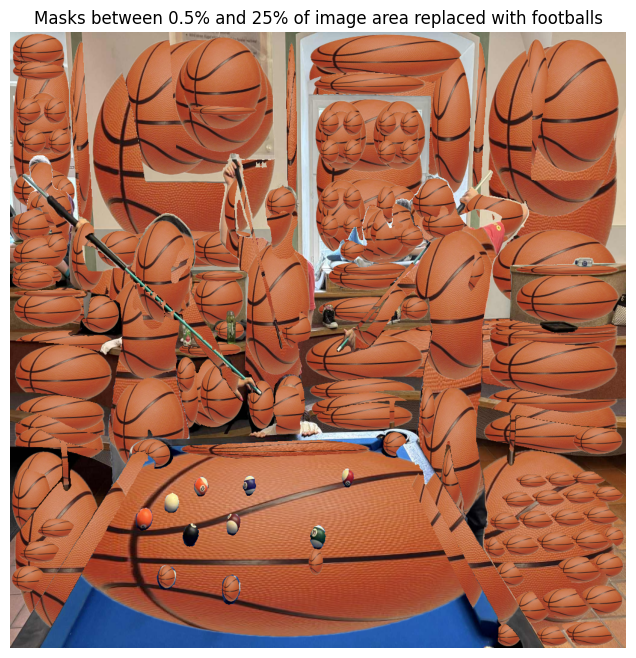

In [81]:
# --- Replace only masks between 0.5% and 1.5% of the total image area ---

import cv2, numpy as np, matplotlib.pyplot as plt, urllib.request, os
from google.colab import files

# ---------- helpers ----------
def imread_rgba(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        h, w = img.shape[:2]
        a = np.full((h, w, 1), 255, np.uint8)
        img = np.concatenate([img, a], axis=2)
    # BGRA -> RGBA
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img

def to_rgba(img_rgb):
    if img_rgb.shape[2] == 3:
        a = np.full(img_rgb.shape[:2] + (1,), 255, np.uint8)
        return np.concatenate([img_rgb, a], axis=2)
    return img_rgb

def alpha_composite(dst_rgba, src_rgba, x, y):
    H, W = dst_rgba.shape[:2]
    h, w = src_rgba.shape[:2]
    if w <= 0 or h <= 0:
        return
    x0, y0 = max(0, int(x)), max(0, int(y))
    x1, y1 = min(W, x0 + int(w)), min(H, y0 + int(h))
    if x1 <= x0 or y1 <= y0:
        return
    sx0, sy0 = x0 - int(x), y0 - int(y)
    sx1, sy1 = sx0 + (x1 - x0), sy0 + (y1 - y0)

    dst = dst_rgba[y0:y1, x0:x1].astype(np.float32)
    src = src_rgba[sy0:sy1, sx0:sx1].astype(np.float32)

    a = src[:, :, 3:4] / 255.0
    out_rgb = a * src[:, :, :3] + (1.0 - a) * dst[:, :, :3]
    out_a   = np.clip(np.maximum(dst[:, :, 3:4], src[:, :, 3:4]), 0, 255)

    dst_rgba[y0:y1, x0:x1, :3] = out_rgb.clip(0, 255).astype(np.uint8)
    dst_rgba[y0:y1, x0:x1, 3:4] = out_a.astype(np.uint8)

def replace_percentile_range_with_football(img_rgb, mask_data, football_rgba,
                                           keep_aspect=True, lower=0.001, upper=0.25):
    """
    Minimal change: interpret 'lower' and 'upper' as FRACTIONS of total image area.
    Example: lower=0.005 (0.5%), upper=0.015 (1.5%).
    """
    H, W = img_rgb.shape[:2]
    total_area = H * W
    lower_bound = lower * total_area
    upper_bound = upper * total_area

    canvas = to_rgba(img_rgb.copy())

    # collect valid masks
    items = []
    for k, info in mask_data.items():
        area = int(info.get("area", 0))
        bbox = info.get("bbox", [0,0,0,0])
        if not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
            continue
        x, y, w, h = bbox
        if area <= 0 or w <= 0 or h <= 0:
            continue
        # FILTER BY ABSOLUTE % OF IMAGE AREA
        if lower_bound <= area <= upper_bound:
            items.append((k, info, area))

    if not items:
        return canvas[:, :, :3]

    # paste larger ones first among selection
    items.sort(key=lambda t: t[2], reverse=True)

    for key, info, area in items:
        x, y, w, h = [int(v) for v in info["bbox"]]
        x = max(0, x); y = max(0, y)
        w = max(1, min(w, W - x)); h = max(1, min(h, H - y))
        if w <= 0 or h <= 0:
            continue

        if keep_aspect:
            fh, fw = football_rgba.shape[:2]
            scale = min(w / fw, h / fh)
            tw, th = max(1, int(round(fw * scale))), max(1, int(round(fh * scale)))
            resized = cv2.resize(football_rgba, (tw, th), interpolation=cv2.INTER_AREA)
            tile = np.zeros((h, w, 4), np.uint8)
            ox, oy = (w - tw) // 2, (h - th) // 2
            tile[oy:oy+th, ox:ox+tw] = resized
        else:
            tile = cv2.resize(football_rgba, (w, h), interpolation=cv2.INTER_AREA)

        seg = info["segmentation"]
        if seg.dtype != np.uint8:
            seg = seg.astype(np.uint8)
        if seg.max() == 1:
            seg = seg * 255
        matte = seg[y:y+h, x:x+w]
        if matte.size == 0:
            continue
        a_tile = tile[:, :, 3]
        combined_alpha = (a_tile.astype(np.float32)/255.0) * (matte.astype(np.float32)/255.0)
        tile_rgba = tile.copy()
        tile_rgba[:, :, 3] = np.clip(combined_alpha * 255.0, 0, 255).astype(np.uint8)

        alpha_composite(canvas, tile_rgba, x, y)

    return canvas[:, :, :3]

# ---------- pick / fetch football image ----------
football_path = None
try:
    uploaded = files.upload()  # optional: upload your football PNG/JPG
    if uploaded:
        football_path = list(uploaded.keys())[0]
except Exception:
    pass

if not football_path:
    football_path = "football_sample.png"
    if not os.path.exists(football_path):
        url = "https://upload.wikimedia.org/wikipedia/commons/0/09/Soccer_ball.svg.png"
        urllib.request.urlretrieve(url, football_path)

football_rgba = imread_rgba(football_path)

# ---------- run replacement on 0.5–1.5% absolute area ----------
out_rgb = replace_percentile_range_with_football(
    img_rgb=img_rgb,           # already defined earlier in your notebook
    mask_data=mask_data,       # already defined earlier in your notebook
    football_rgba=football_rgba,
    keep_aspect=False,
    lower=0.001,   # 0.5% of total image area
    upper=0.25    # 1.5% of total image area
)

plt.figure(figsize=(8,8))
plt.imshow(out_rgb)
plt.axis("off")
plt.title("Masks between 0.5% and 25% of image area replaced with footballs")
plt.show()

In [26]:
# --- Replace only masks between 0.5% and 1.5% of total image area using MULTIPLE uploaded images ---

import cv2, numpy as np, matplotlib.pyplot as plt, urllib.request, os
from google.colab import files

# ---------- helpers ----------
def imread_rgba(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        h, w = img.shape[:2]
        a = np.full((h, w, 1), 255, np.uint8)
        img = np.concatenate([img, a], axis=2)
    # BGRA -> RGBA
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img

def auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.20):
    """Key out border color in LAB space; keep foreground, make background transparent."""
    rgb = rgba[:, :, :3]
    H, W = rgb.shape[:2]
    border = np.concatenate([rgb[0], rgb[-1], rgb[:,0], rgb[:,-1]], axis=0).astype(np.uint8)
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    border_lab = cv2.cvtColor(border.reshape(-1,1,3), cv2.COLOR_RGB2LAB).reshape(-1,3)
    ref = np.median(border_lab, axis=0)
    d = lab.astype(np.float32)
    dist = np.sqrt(np.sum((d - ref.reshape(1,1,3))**2, axis=2))
    bg_mask = (dist < thresh).astype(np.uint8)*255

    # Keep background connected to image edges
    flood = np.zeros((H+2, W+2), np.uint8)
    bg_ff = bg_mask.copy()
    for seed in [(0,0),(W-1,0),(0,H-1),(W-1,H-1)]:
        try: cv2.floodFill(bg_ff, flood, seed, 254)
        except: pass
    bg_connected = (bg_ff == 254).astype(np.uint8)*255

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    bg_connected = cv2.morphologyEx(bg_connected, cv2.MORPH_OPEN, k, iterations=1)
    bg_connected = cv2.morphologyEx(bg_connected, cv2.MORPH_CLOSE, k, iterations=1)

    fg = (bg_connected == 0).astype(np.uint8)
    new_alpha = (fg * 255).astype(np.uint8)

    if new_alpha.sum() < min_keep_ratio * 255 * H * W:
        new_alpha = 255 - bg_connected  # safety flip if we removed too much

    out = rgba.copy()
    out[:, :, 3] = np.minimum(out[:, :, 3], new_alpha)  # respect existing alpha
    return out

def to_rgba(img_rgb):
    if img_rgb.shape[2] == 3:
        a = np.full(img_rgb.shape[:2] + (1,), 255, np.uint8)
        return np.concatenate([img_rgb, a], axis=2)
    return img_rgb

def alpha_composite(dst_rgba, src_rgba, x, y):
    H, W = dst_rgba.shape[:2]
    h, w = src_rgba.shape[:2]
    if w <= 0 or h <= 0: return
    x0, y0 = max(0, int(x)), max(0, int(y))
    x1, y1 = min(W, x0 + int(w)), min(H, y0 + int(h))
    if x1 <= x0 or y1 <= y0: return
    sx0, sy0 = x0 - int(x), y0 - int(y)
    sx1, sy1 = sx0 + (x1 - x0), sy0 + (y1 - y0)

    dst = dst_rgba[y0:y1, x0:x1].astype(np.float32)
    src = src_rgba[sy0:sy1, sx0:sx1].astype(np.float32)

    a = src[:, :, 3:4] / 255.0
    out_rgb = a * src[:, :, :3] + (1.0 - a) * dst[:, :, :3]
    out_a   = np.maximum(dst[:, :, 3:4], src[:, :, 3:4])
    dst_rgba[y0:y1, x0:x1, :3] = out_rgb.clip(0, 255).astype(np.uint8)
    dst_rgba[y0:y1, x0:x1, 3:4] = out_a.clip(0, 255).astype(np.uint8)

def replace_area_fraction_with_tiles(img_rgb, mask_data, tiles_rgba,
                                     keep_aspect=True, lower=0.005, upper=0.015):
    """
    Replace masks whose areas are within [lower, upper] fraction of total image area.
    Distribute multiple tiles round-robin over selected masks.
    """
    H, W = img_rgb.shape[:2]
    total_area = H * W
    low_px = lower * total_area
    high_px = upper * total_area

    canvas = to_rgba(img_rgb.copy())

    # Collect masks within absolute area range
    items = []
    for k, info in mask_data.items():
        area = int(info.get("area", 0))
        bbox = info.get("bbox", [0,0,0,0])
        if not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
            continue
        x, y, w, h = bbox
        if area <= 0 or w <= 0 or h <= 0:
            continue
        if low_px <= area <= high_px:
            items.append((k, info, area))

    if not items or not tiles_rgba:
        return canvas[:, :, :3]

    # Paste larger ones first for nicer overlaps
    items.sort(key=lambda t: t[2], reverse=True)

    m = len(tiles_rgba)
    for idx, (key, info, area) in enumerate(items):
        tile_src = tiles_rgba[idx % m]

        x, y, w, h = [int(v) for v in info["bbox"]]
        x = max(0, x); y = max(0, y)
        w = max(1, min(w, W - x)); h = max(1, min(h, H - y))
        if w <= 0 or h <= 0: continue

        if keep_aspect:
            fh, fw = tile_src.shape[:2]
            scale = min(w / fw, h / fh)
            tw, th = max(1, int(round(fw * scale))), max(1, int(round(fh * scale)))
            resized = cv2.resize(tile_src, (tw, th), interpolation=cv2.INTER_AREA)
            # letterbox into bbox
            tile = np.zeros((h, w, 4), np.uint8)
            ox, oy = (w - tw) // 2, (h - th) // 2
            tile[oy:oy+th, ox:ox+tw] = resized
        else:
            tile = cv2.resize(tile_src, (w, h), interpolation=cv2.INTER_AREA)

        seg = info["segmentation"].astype(np.uint8)
        if seg.max() == 1: seg *= 255
        matte = seg[y:y+h, x:x+w]
        if matte.size == 0: continue

        a_tile = tile[:, :, 3]
        combined_alpha = (a_tile.astype(np.float32)/255.0) * (matte.astype(np.float32)/255.0)
        tile_rgba = tile.copy()
        tile_rgba[:, :, 3] = np.clip(combined_alpha * 255.0, 0, 255).astype(np.uint8)

        alpha_composite(canvas, tile_rgba, x, y)

    return canvas[:, :, :3]

# ---------- upload MULTIPLE images (tiles) ----------
print("Select one or more images (PNG/JPG/WEBP). We'll auto-remove their backgrounds.")
uploads = files.upload()  # you can select multiple files here
tile_paths = list(uploads.keys())

# Fallback tiles if nothing uploaded
if not tile_paths:
    tile_paths = []
    urls = [
        "https://upload.wikimedia.org/wikipedia/commons/0/09/Soccer_ball.svg.png",
        "https://upload.wikimedia.org/wikipedia/commons/8/80/Basketball.png"
    ]
    for i, url in enumerate(urls):
        p = f"tile_{i}.png"
        urllib.request.urlretrieve(url, p)
        tile_paths.append(p)

tiles_rgba = []
for p in tile_paths:
    rgba = imread_rgba(p)
    rgba = auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.15)
    tiles_rgba.append(rgba)



Select one or more images (PNG/JPG/WEBP). We'll auto-remove their backgrounds.


Saving Basketball.png to Basketball (2).png


How many images do you want to upload? 7

Upload image 1 of 7 …


Saving stick8.jpg to stick8 (1).jpg

Upload image 2 of 7 …


Saving stick7.jpg to stick7 (1).jpg

Upload image 3 of 7 …


Saving stick6.jpg to stick6 (1).jpg

Upload image 4 of 7 …


Saving stick4.jpg to stick4 (1).jpg

Upload image 5 of 7 …


Saving stick2.jpg to stick2 (1).jpg

Upload image 6 of 7 …


Saving stick.jpg to stick (1).jpg

Upload image 7 of 7 …


Saving unicorn-transparent-background_1085577-83520.jpg to unicorn-transparent-background_1085577-83520 (1).jpg

Collected 7 images: ['stick8 (1).jpg', 'stick7 (1).jpg', 'stick6 (1).jpg', 'stick4 (1).jpg', 'stick2 (1).jpg', 'stick (1).jpg', 'unicorn-transparent-background_1085577-83520 (1).jpg']


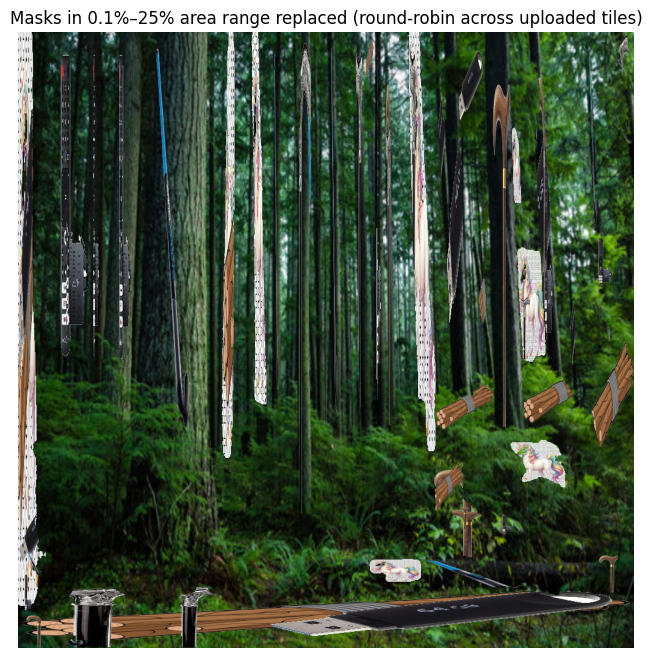

In [103]:
# --- Replace masks between 0.5% and 1.5% of total image area using N user-uploaded images ---

import cv2, numpy as np, matplotlib.pyplot as plt, urllib.request, os
from google.colab import files

# ---------- helpers ----------
def imread_rgba(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        h, w = img.shape[:2]
        a = np.full((h, w, 1), 255, np.uint8)
        img = np.concatenate([img, a], axis=2)
    # BGRA -> RGBA
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img

def auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.20):
    """
    Remove background by keying approximate border color in LAB space + cleanup.
    Works well for product-style images with uniform-ish borders; preserves existing alpha.
    """
    rgb = rgba[:, :, :3]
    H, W = rgb.shape[:2]
    border = np.concatenate([rgb[0], rgb[-1], rgb[:,0], rgb[:,-1]], axis=0).astype(np.uint8)
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    border_lab = cv2.cvtColor(border.reshape(-1,1,3), cv2.COLOR_RGB2LAB).reshape(-1,3)
    ref = np.median(border_lab, axis=0)
    d = lab.astype(np.float32)
    dist = np.sqrt(np.sum((d - ref.reshape(1,1,3))**2, axis=2))
    bg_mask = (dist < thresh).astype(np.uint8)*255

    # Keep background connected to edges
    flood = np.zeros((H+2, W+2), np.uint8)
    bg_ff = bg_mask.copy()
    for seed in [(0,0),(W-1,0),(0,H-1),(W-1,H-1)]:
        try: cv2.floodFill(bg_ff, flood, seed, 254)
        except: pass
    bg_connected = (bg_ff == 254).astype(np.uint8)*255

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    bg_connected = cv2.morphologyEx(bg_connected, cv2.MORPH_OPEN, k, iterations=1)
    bg_connected = cv2.morphologyEx(bg_connected, cv2.MORPH_CLOSE, k, iterations=1)

    fg = (bg_connected == 0).astype(np.uint8)
    new_alpha = (fg * 255).astype(np.uint8)

    # Safety: if we removed too much, invert decision
    if new_alpha.sum() < min_keep_ratio * 255 * H * W:
        new_alpha = 255 - bg_connected

    out = rgba.copy()
    out[:, :, 3] = np.minimum(out[:, :, 3], new_alpha)  # respect existing alpha
    return out

def to_rgba(img_rgb):
    if img_rgb.shape[2] == 3:
        a = np.full(img_rgb.shape[:2] + (1,), 255, np.uint8)
        return np.concatenate([img_rgb, a], axis=2)
    return img_rgb

def alpha_composite(dst_rgba, src_rgba, x, y):
    H, W = dst_rgba.shape[:2]
    h, w = src_rgba.shape[:2]
    if w <= 0 or h <= 0: return
    x0, y0 = max(0, int(x)), max(0, int(y))
    x1, y1 = min(W, x0 + int(w)), min(H, y0 + int(h))
    if x1 <= x0 or y1 <= y0: return
    sx0, sy0 = x0 - int(x), y0 - int(y)
    sx1, sy1 = sx0 + (x1 - x0), sy0 + (y1 - y0)

    dst = dst_rgba[y0:y1, x0:x1].astype(np.float32)
    src = src_rgba[sy0:sy1, sx0:sx1].astype(np.float32)

    a = src[:, :, 3:4] / 255.0
    out_rgb = a * src[:, :, :3] + (1.0 - a) * dst[:, :, :3]
    out_a   = np.maximum(dst[:, :, 3:4], src[:, :, 3:4])
    dst_rgba[y0:y1, x0:x1, :3] = out_rgb.clip(0, 255).astype(np.uint8)
    dst_rgba[y0:y1, x0:x1, 3:4] = out_a.clip(0, 255).astype(np.uint8)

def replace_area_fraction_with_tiles(img_rgb, mask_data, tiles_rgba,
                                     keep_aspect=True, lower=0.005, upper=0.5):
    """
    Replace masks whose areas are within [lower, upper] fraction of total image area.
    Distribute multiple tiles round-robin over selected masks.
    """
    H, W = img_rgb.shape[:2]
    total_area = H * W
    low_px = lower * total_area
    high_px = upper * total_area

    canvas = to_rgba(img_rgb.copy())

    # Collect masks within absolute area range
    items = []
    for k, info in mask_data.items():
        area = int(info.get("area", 0))
        bbox = info.get("bbox", [0,0,0,0])
        if not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
            continue
        x, y, w, h = bbox
        if area <= 0 or w <= 0 or h <= 0:
            continue
        if low_px <= area <= high_px:
            items.append((k, info, area))

    if not items or not tiles_rgba:
        return canvas[:, :, :3]

    # Paste larger ones first for nicer overlaps
    items.sort(key=lambda t: t[2], reverse=True)

    m = len(tiles_rgba)
    for idx, (key, info, area) in enumerate(items):
        tile_src = tiles_rgba[idx % m]

        x, y, w, h = [int(v) for v in info["bbox"]]
        x = max(0, x); y = max(0, y)
        w = max(1, min(w, W - x)); h = max(1, min(h, H - y))
        if w <= 0 or h <= 0: continue

        if keep_aspect:
            fh, fw = tile_src.shape[:2]
            scale = min(w / fw, h / fh)
            tw, th = max(1, int(round(fw * scale))), max(1, int(round(fh * scale)))
            resized = cv2.resize(tile_src, (tw, th), interpolation=cv2.INTER_AREA)
            # letterbox into bbox
            tile = np.zeros((h, w, 4), np.uint8)
            ox, oy = (w - tw) // 2, (h - th) // 2
            tile[oy:oy+th, ox:ox+tw] = resized
        else:
            tile = cv2.resize(tile_src, (w, h), interpolation=cv2.INTER_AREA)

        seg = info["segmentation"].astype(np.uint8)
        if seg.max() == 1: seg *= 255
        matte = seg[y:y+h, x:x+w]
        if matte.size == 0: continue

        a_tile = tile[:, :, 3]
        combined_alpha = (a_tile.astype(np.float32)/255.0) * (matte.astype(np.float32)/255.0)
        tile_rgba = tile.copy()
        tile_rgba[:, :, 3] = np.clip(combined_alpha * 255.0, 0, 255).astype(np.uint8)

        alpha_composite(canvas, tile_rgba, x, y)

    return canvas[:, :, :3]

# ---------- prompt for N images and upload one-by-one ----------
while True:
    try:
        n_imgs = int(input("How many images do you want to upload? "))
        if n_imgs <= 0:
            print("Please enter a positive integer.")
            continue
        break
    except Exception:
        print("Please enter a valid integer.")

tiles_rgba = []
picked = []

for i in range(n_imgs):
    print(f"\nUpload image {i+1} of {n_imgs} …")
    up = files.upload()   # user picks one file here
    if not up:
        print("No file selected; skipping this slot.")
        continue
    fname = list(up.keys())[0]  # if multiple selected, take the first
    picked.append(fname)
    rgba = imread_rgba(fname)
    rgba = auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.15)
    tiles_rgba.append(rgba)

print(f"\nCollected {len(tiles_rgba)} images:", picked if picked else "(none)")

# Fallback if none uploaded
if not tiles_rgba:
    print("No uploads detected; using two sample tiles as fallback.")
    urls = [
        "https://upload.wikimedia.org/wikipedia/commons/0/09/Soccer_ball.svg.png",
        "https://upload.wikimedia.org/wikipedia/commons/8/80/Basketball.png"
    ]
    for i, url in enumerate(urls):
        p = f"tile_fallback_{i}.png"
        urllib.request.urlretrieve(url, p)
        rgba = imread_rgba(p)
        rgba = auto_make_background_transparent(rgba, thresh=18, min_keep_ratio=0.15)
        tiles_rgba.append(rgba)

# ---------- run replacement on the 0.5%–1.5% area range ----------
out_rgb = replace_area_fraction_with_tiles(
    img_rgb=img_rgb,          # must already exist from your SAM step
    mask_data=mask_data,      # must already exist from your SAM step
    tiles_rgba=tiles_rgba,
    keep_aspect=False,
    lower=0.001,              # 0.5% of total image area
    upper=0.5               # 1.5% of total image area
)

plt.figure(figsize=(8,8))
plt.imshow(out_rgb)
plt.axis("off")
plt.title("Masks in 0.1%–50% area range replaced (round-robin across uploaded tiles)")
plt.show()
